Importamos funciones

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

In [2]:
from collections import deque
import random

Leemos grafo

In [83]:
path_geom = '../data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path_geom, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
     
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

Tree = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        Tree.add_edge(id_[origin], id_[dest])
        
G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
    
N = l

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

Obtenemos carácterísticas del grafo

## Algoritmo
Parámetros iniciales

In [52]:
J = N
J = 30 # N
O = deque([0], int(1e6)) #0 es WTF
S = 0
#F_l = #largo de calles
#P_n = # cantidad de salidas desde el nodo
G = nx.DiGraph()
l = 0

Main loop

In [103]:
while True:
    # Parámetros
    J = N
    J = 40 # N
    O = deque([0], int(1e4)) #0 es WTF
    S = 0
    F_l = list(range(1,6)) # Largo de las calles
    P_n = [1, 1, 1, 1, 2, 2, 3, 3, 4] # cantidad de salidas desde el nodo
    G = nx.DiGraph()
    l = 0
    
    # Main loop
    while O: 
        # nts: next_tree_segment
        nts = O.popleft()
        growth = random.choice(P_n) 
        lenght_ = random.sample(F_l, growth)
        
        for i in range(1, growth + 1):
            G.add_edge(l + i, nts, length = lenght_[i - 1])
            O.append(l+i)
            
        l += growth
        S += growth
        
        
        if S >= J:
            break
    
    if len(G.nodes()) > J:
        break

In [104]:
len(G.nodes())

41

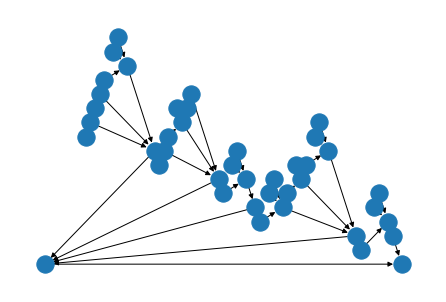

In [105]:
layout = nx.planar_layout(G)
nx.draw(G, pos = layout, with_labels = False )

In [99]:
max_depth = 15
T = Tree.subgraph([node for node in list(Tree.nodes()) if nx.shortest_path_length(Tree, source = node, target = 744) <= max_depth])
print(len(T.nodes()))

42


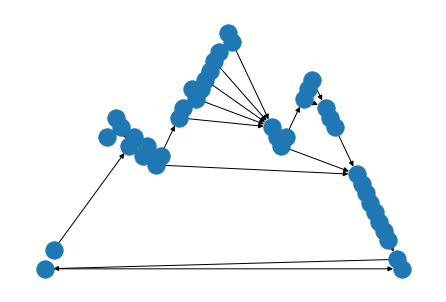

In [101]:
layout = nx.planar_layout(T)
nx.draw(T, pos = layout, with_labels = False )